# NETWORK OPTIMIZATION AND NON-LINEAR MODELS

**Name:** Marina Rodríguez Hernández

**NIA:** 100429893

## Network optimization



For this second project, I tried to do a re-adaptation of the minimum cost flow problem applying it to a real life situation.

A company needs to send 90 workers from Madrid to Moscow for an important conference. The company doesn't mind if the workers don't go in the same planes, they just want for the trip to be as cheap as posible.

The problem is defined by the following graph, which represents the network of different flights in Europe.

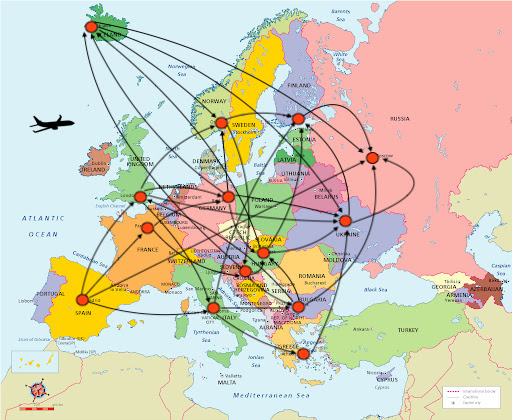

The **variables** are the different nodes, which are the cities where the flights go to. In total there are 14 cities. Madrid is a supply node while Moscow is the demand node. The other cities aren't 'supply or demanding' any workers.

In [267]:
import numpy as np

#Input data

Madrid=0
London=1
Rome=2
Paris=3
Berlin=4
Sofia=5
Budapest=6
Zagreb=7
Reykjavik=8
Athens=9
Oslo=10
Helsinki=11
Kiev=12
Moscow=13

I need to define the starting and ending nodes, as well as the capacities (number of seats available in the plane) and costs (cost per ticket) of each flight. It is also needed to define the cities where that will be supplying or demanding workers.

In [268]:
start_nodes = [Madrid, Madrid, Madrid, Madrid, London, London,London,London, Rome, Rome,Rome, Sofia, Sofia, Sofia, Budapest, Budapest, Budapest, Reykjavik, Reykjavik, Reykjavik, Paris,Paris,Athens, Berlin,Berlin,Berlin,Berlin, Zagreb,Zagreb,Zagreb, Oslo,Oslo, Helsinki, Kiev, Kiev]
end_nodes   = [London, Moscow, Rome, Paris,Rome, Kiev, Oslo,Berlin, Sofia, Helsinki,Athens, Budapest, London, Moscow, Kiev, Reykjavik, Helsinki, Kiev, Moscow, Oslo, Berlin,Zagreb,Kiev, Oslo,Reykjavik,Budapest,Kiev, Reykjavik,Budapest,Sofia, Zagreb,Helsinki, Moscow, Helsinki, Moscow]

capacities  = [70, 20, 35, 25, 50, 15, 20, 35, 55, 15, 30, 35, 25, 15, 20, 35, 30, 25, 35, 10, 20,15, 40, 20, 10, 25, 10, 20, 10, 15, 25, 35, 135, 50, 80]
unit_costs  = [25, 50, 20, 15, 15, 30, 25, 15, 10, 25, 25, 10, 15, 25, 20, 15, 15, 20, 25, 20, 10, 15, 30, 25, 20, 25, 15, 10, 10, 15, 25, 10, 20, 10, 26]
supplies = [90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -90]

Then, I need to create the A matrix, that basically shows the connections between the cities.

In [270]:
A = np.zeros((len(supplies),len(start_nodes)))
def generateA (A,start_nodes,end_nodes):
    count = 0
    for i in zip(start_nodes,end_nodes):
        A[i[0]][count] = 1
        A[i[1]][count] = -1
        count+=1
        
generateA(A,start_nodes,end_nodes)
print('Number of cities: ',len(A))
print('Number of flights: ',len(A.T))

Number of cities:  14
Number of flights:  35


Finally, we define the variables, the objective and the constraints. As I said before, the **variables** are the different cities. The **objective** is to minimize the cost of the flights of the 90 workers. The **constraints** are that it has to take into account the supply in each node in order to take all the workers to Moscow, and that the number of workers in each flight can't exceed the capacities of the planes.

In [271]:
from pyomo.environ import *

# Create the model
model = ConcreteModel()

# Initialize some ranges for the constraint and objective definition 
model.r = RangeSet(1,len(A)) #14
model.j = RangeSet(1,len(A.T)) #35

##Variables
model.flow=Var(model.j, domain=NonNegativeReals)

##Objective
def objective_rule(model):
    return sum(model.flow[i]*unit_costs[i-1] for i in model.j)

model.obj = Objective(rule=objective_rule, sense=minimize)

##Constraints

#Supplies in each node
model.supply = ConstraintList()
for i in model.r:
    model.supply.add(sum(A[i-1][j-1]*model.flow[j] for j in model.j) >= supplies[i-1])

#Maximum capacity
model.capacity = ConstraintList()
for i in model.j:
    model.capacity.add(model.flow[i] <= capacities[i-1])

To obtain the solution, I will use the glpk solver

In [272]:
# Solution
opt = SolverFactory('glpk')

results = opt.solve(model) 
 
model.display()

Model unknown

  Variables:
    flow : Size=35, Index=j
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  10.0 :  None : False : False : NonNegativeReals
          2 :     0 :  20.0 :  None : False : False : NonNegativeReals
          3 :     0 :  35.0 :  None : False : False : NonNegativeReals
          4 :     0 :  25.0 :  None : False : False : NonNegativeReals
          5 :     0 :   0.0 :  None : False : False : NonNegativeReals
          6 :     0 :   0.0 :  None : False : False : NonNegativeReals
          7 :     0 :  10.0 :  None : False : False : NonNegativeReals
          8 :     0 :   0.0 :  None : False : False : NonNegativeReals
          9 :     0 :  20.0 :  None : False : False : NonNegativeReals
         10 :     0 :  15.0 :  None : False : False : NonNegativeReals
         11 :     0 :   0.0 :  None : False : False : NonNegativeReals
         12 :     0 :   5.0 :  None : False : False : NonNegativeReals
         13 :     0 :   0.0 :  

In [250]:
print('Total cost: ', model.obj())

Total cost:  2785.0


Workers that must go in each flight:

$Flight$ | $Workers$
 -------|---
  $Madrid$ --> $London$ | 10 
  $Madrid$ --> $Moscow$ | 20  
  $Madrid$ --> $Rome$ | 35  
  $Madrid$ --> $Paris$ | 25  
  $London$ --> $Rome$ | 0   
  $London$ --> $Kiev$ | 0   
  $London$ --> $Oslo$ | 10   
  $London$ --> $Berlin$ | 0  
  $Rome$ --> $Sofia$ | 20  
  $Rome$ --> $Helsinki$ | 15  
  $Rome$ --> $Athend$ | 0 
  $Sofia$ --> $Budapest$ | 5  
  $Sofia$ --> $London$ | 0 
  $Sofia$ --> $Moscow$ | 15  
  $Budapest$ --> $Kiev$ | 0   
  $Budapest$ --> $Reykjavik$ | 0  
  $Budapest$ --> $Helsinki$ | 5  
  $Reykjavik$ --> $Kiev$ | 0  
  $Reykjavik$ --> $Moscow$ | 15   
  $Reykjavik$ --> $Oslo$ | 0   
  $Paris$ --> $Berlin$ | 10  
  $Paris$ --> $Zagreb$ | 15   
  $Athens$ --> $Kiev$ | 0   
  $Berlin$ --> $Oslo$ | 0  
  $Berlin$ --> $Reykjavik$ | 0  
  $Berlin$ --> $Budapest$ | 0 
  $Berlin$ --> $Kiev$ | 10  
  $Zagreb$ --> $Reykjavik$ | 15  
  $Zagreb$ --> $Budapest$ | 0  
  $Zagreb$ --> $Sofia$ | 0  
  $Oslo$ --> $Zagreb$ | 0  
  $Oslo$ --> $Helsinki$ | 10  
  $Helsinki$ --> $Moscow$ | 30  
  $Kiev$ --> $Helsinki$ | 0  
  $Kiev$ --> $Moscow$ | 10  
  
  

In the table above we can see the number of workers that have to go in each flight in order for the company to have the minimum possible cost.

## Non-linear optimization

For this problem, I will be using the dataset of a hospital. The hospital needs to do many operations with the minimum cost possible. Each procedure has a specific cost, but depending on the group it belongs to (depending on the diagnostic of the patient), the total cost of the procedure changes with a formula I will explain later. The hospital has a budget of 5000 and we need to minimize the total of the cost getting as many procedures done as we can.

Problem formulation:

· **Decision variables:** different procedures

· **Objective:** minimize the total cost of the procedures

· **Constraints:** maximum cost (budget), minimum cost, minimum number of each procedure, maximum number of each 
procedure

In order to do this, I will be using a data set that shows:

· An identifier for each patient

· The diagnostic they have

· The procedure they need

· The group they belong to, depending on their diagnositc

· The default cost of each operation (without taking into account the diagnostic)

In total it has 5 columns and 26 rows

In [273]:
# Import data using pandas
import pandas as pd

#Read excel with data
df = pd.read_excel('Waiting3.xlsx')  
print(df)

    Patient                         Diagnostic                     Procedure  \
0         1                                HB4             Abordaje anterior   
1         2                 Quiste coloide III          Abordaje endoscópico   
2         3                                HDC           Artrodesis cervical   
3         4                 Artrodesis lumbar              Artrodesis lumbar   
4         5            Defecto  craneal posTCE                 Craneoplastia   
5         6              Lesión lítica craneal                   Craneotomía   
6         7         Estenosis de canal  lumbar                 Descompresión   
7         8                     HDC4-5 y c5-c6     Disc c3-c4 yc 4-c5 + PEEK   
8         9                     HDC5-6 y c6-c7                     Disc caja   
9        10                Mielopatia cervical               disc caja placa   
10       11                         HDC5-6+4-5                      Disc+art   
11       12                     HDC5-6 y

In [274]:
proc = list(set(df['Procedure'])) 

Group = df.set_index(['Procedure'])['Group'].to_dict()

Cost = df.set_index(['Procedure'])['Cost'].to_dict()

First of all, I imported the dataset calling it df. Then I created different lists and dictionaries.

· proc is a list with all the different procedures, these will be my **variables**

· Group is a dictionary with the different procedures and the time it takes to operate them

· Cost is a dictionary with the default cost of the different procedures

Then, we need to define the model, the variables, and the objective.
As I said before, the variables are the different procedures, and I will try to calculate how many can a hospital do with the minimum possible cost. The **objective** consists in minimizing the total cost, which is obtained with the following equation: 
$\min\ (procedure_i - group_i)^2 + cost_i$

In [275]:
## DEFINE MODEL ##
model = ConcreteModel()

#Define the variables
model.x=Var(proc, within=NonNegativeReals)

#Define the objective: minimize the cost of the procedures
def obj_expression(model):
    return sum((model.x[i]-Group[i])**2 + Cost[i]  for i in proc)

model.objective=Objective(rule=obj_expression, sense=minimize)

After this, I need to define the **constraints**. I defined the maximum possible cost (5000 euros), the minimum (50 euros), the maximum number of each procedure (5) and the minimum (1).

In [276]:
#Constraints
def upper_limit(model):
    suma= sum((model.x[i]-Group[i])**2 + Cost[i]  for i in proc) 
    return suma <= 5000

model.constraint1=Constraint(rule=upper_limit)

def lower_limit(model):
    suma= sum((model.x[i]-Group[i])**2 + Cost[i]  for i in proc) 
    return suma >= 50

model.constraint2=Constraint(rule=lower_limit)

model.all_one = ConstraintList()
for i in model.x:
    model.all_one.add(expr = model.x[i] >= 1)

model.all_five = ConstraintList()
for i in model.x:
    model.all_five.add(expr = model.x[i] <= 5)

To obtain the solution, I will use the ipopt solver

In [277]:
solver= SolverFactory('ipopt')

results = solver.solve(model) 

model.display()

Model unknown

  Variables:
    x : Size=26, Index=x_index
        Key                          : Lower : Value              : Upper : Fixed : Stale : Domain
                   Abordaje anterior :     0 : 3.5000000000238534 :  None : False : False : NonNegativeReals
                Abordaje endoscópico :     0 : 3.9999999994779243 :  None : False : False : NonNegativeReals
                 Artrodesis cervical :     0 :  3.000000000417638 :  None : False : False : NonNegativeReals
                   Artrodesis lumbar :     0 : 3.5000000000238534 :  None : False : False : NonNegativeReals
                       Craneoplastia :     0 :  3.000000000417638 :  None : False : False : NonNegativeReals
                         Craneotomía :     0 :  4.499999998130504 :  None : False : False : NonNegativeReals
                       Descompresión :     0 : 2.0000000014617645 :  None : False : False : NonNegativeReals
           Disc c3-c4 yc 4-c5 + PEEK :     0 :  1.500000002983206 :  None : Fal

In [278]:
print("Total cost=",model.objective())

Total cost= 4230.250000008603


This **solution** shows that in order to minimize the cost, the hospital needts to do the following number of procedures

In [279]:
print('\nNumber of procedures:')
for i in proc:
    print(i,': ', value(model.x[i])) 


Number of procedures:
Exéresis :  1.0000517956995798
Fusión :  3.000000000417638
Microdiscectomía :  1.0000517956995798
Discectomía artrodesis. :  1.0000517956995798
Discectomía DIE :  2.0000000014617645
Craneotomía :  4.499999998130504
Disc c3-c4 yc 4-c5 + PEEK :  1.500000002983206
Disc+art :  2.5000000008352887
Embolización :  2.5000000008352887
Laminectomía :  2.5000000008352887
Fusión Lumbar :  1.0000517956995798
Discectomía :  1.500000002983206
Descompresión :  2.0000000014617645
disc caja placa :  2.0000000014617645
Craneoplastia :  3.000000000417638
Discectomía doble y caja :  1.0000517956995798
Retirada tornillos  :  1.0000517956995798
Abordaje anterior :  3.5000000000238534
Abordaje endoscópico :  3.9999999994779243
Disc+Peek :  1.500000002983206
P80.51 :  1.500000002983206
Terapia intratecal Baclofeno :  1.500000002983206
Artrodesis cervical :  3.000000000417638
Artrodesis lumbar :  3.5000000000238534
Discectomía+ foraminotomía :  0.9999999925059035
Disc caja :  2.5000000008